# Importação de pacotes

In [7]:
import pandas as pd
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from prov.model import ProvDocument
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image

# Proveniência

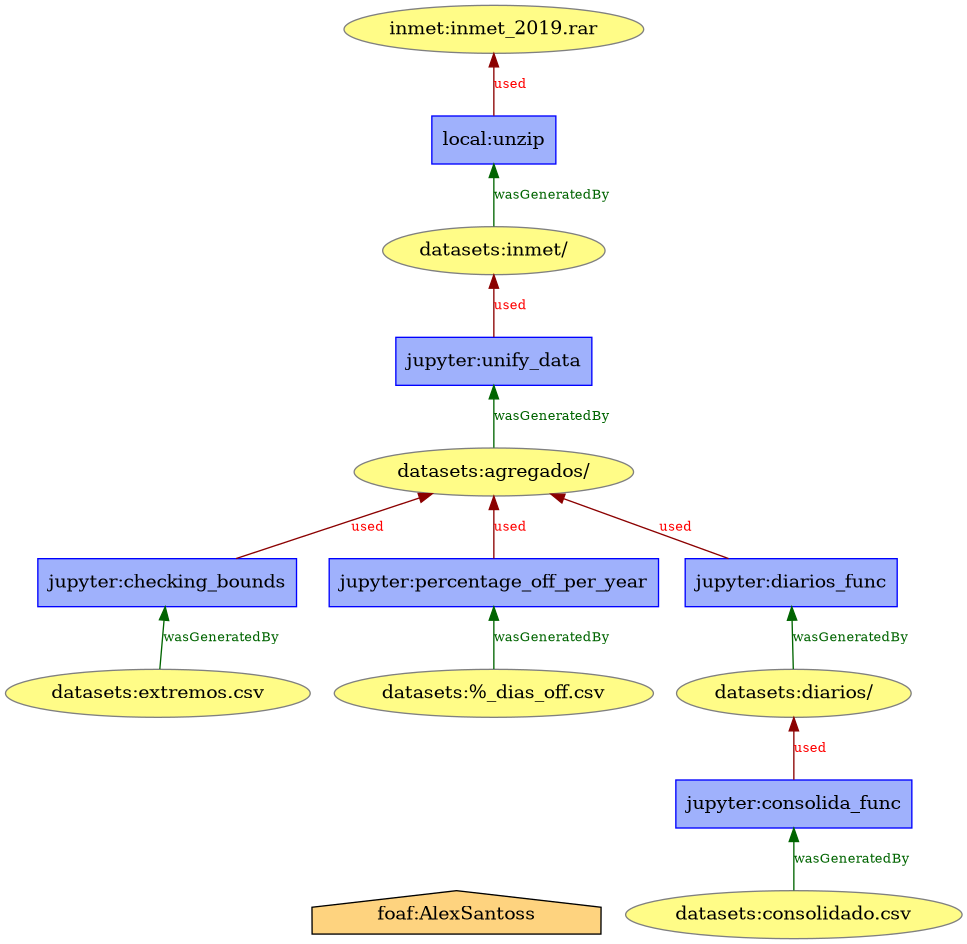

Bad pipe message: %s [b'ecure-Requests: 1\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) QtWebEn', b'ne/5.15.5 Chrome/87.0.4280.144 Safari/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;', b'0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9\r\nDNT: 1\r\nAccept-Language: ', b'-US,en;q=0.9\r\nSec-Fetch-Site: none\r\nSec-Fetch-Mode: navigate\r\nSec-Fetch-User: ?1\r\nSec-Fetch-Dest: do']


In [42]:
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
d1.add_namespace('inmet', 'https://portal.inmet.gov.br/dadoshistoricos')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('datasets', 'datasets/')
d1.add_namespace('jupyter', 'AvaliacaoDados.ipynb')
d1.add_namespace('local', 'zip')

# Adding an Agent 
agent = 'foaf:AlexSantoss'
d1.agent(agent)

# Adding an entity
entity = 'inmet:inmet_2019.rar'
e1 = d1.entity(entity)

entity = 'datasets:inmet/'
e2 = d1.entity(entity)

entity = 'datasets:agregados/'
e3 = d1.entity(entity)

entity = 'datasets:extremos.csv'
e4 = d1.entity(entity)

entity = 'datasets:%_dias_off.csv'
e5 = d1.entity(entity)

entity = 'datasets:diarios/'
e6 = d1.entity(entity)

entity = 'datasets:consolidado.csv'
e7 = d1.entity(entity)


#Generation
a1 = 'local:unzip'
d1.activity(a1)

a2 = 'jupyter:unify_data'
d1.activity(a2)

a3 = 'jupyter:checking_bounds'
d1.activity(a3)

a4 = 'jupyter:percentage_off_per_year'
d1.activity(a4)

a5 = 'jupyter:diarios_func'
d1.activity(a5)

a6 = 'jupyter:consolida_func'
d1.activity(a6)

#Relations
d1.used(a1, e1)
d1.wasGeneratedBy(e2, a1)
d1.used(a2, e2)
d1.wasGeneratedBy(e3, a2)
d1.used(a3, e3)
d1.wasGeneratedBy(e4, a3)
d1.used(a4, e3)
d1.wasGeneratedBy(e5, a4)
d1.used(a5, e3)
d1.wasGeneratedBy(e6, a5)
d1.used(a6, e6)
d1.wasGeneratedBy(e7, a6)



dot = prov_to_dot(d1)
graph = "dot.png"
dot.write_png(graph)
Image(graph)

In [19]:
#definicões de variáveis
path_inmet = 'datasets/inmet' #caminho para os arquivos do inmet
path_output = 'datasets/agregados' #caminho para onde deseja que as planilhas por estação sejam inseridas
padronizar_dados = True #defina true se deseja que a padronização seja feita (precisa dos arquivos do inmet)

In [20]:
## Conjunto de funções para unificar e padronizar os datasets
colunas_importantes = [0, 1, 2, 6, 9, 10, 13, 14, 18]
index_metadados = ['REGIÃO', 'UF', 'ESTAÇÃO', 'CODIGO (WMO)', 'LATITUDE', 'LONGITUDE', 'ALTITUDE', 'DATA DE FUNDAÇÃO']

 #troca / por - e adiciona o 20 na frente
def formata_data(dt):
    if '/' not in dt: return dt
    d, m, a = dt.split('/')
    return f'20{a}-{m}-{d}'


#troca / por - e remove 'UTC' das strings de hora
def formata_data_hora(mi):
    data, hora = mi[0].replace('/', '-'), mi[1].replace(' UTC', '')
    if len(hora) == 4:  hora = hora[:2] + ':' + hora[2:]
    return data, hora


#faz a leitura de cada arquivo e concatena
def concat_years(code, file_list, output_dir):
    lla_data = [] #geographic data
    sensor_data = [] #sensor data
    for file in file_list:
        #leitura dos sensores
        df = pd.read_csv(file, skiprows=8, encoding='latin_1', sep=';', decimal=',', usecols=colunas_importantes, index_col=[0, 1], na_values=[-9999])
        df = df.rename_axis(['Data', 'Hora']).rename(columns={ df.columns[1]: 'RADIACAO GLOBAL (KJ/m²)'})
        sensor_data.append(df)
        
        #leitura dos dados geograficos
        md = pd.read_csv(file, encoding='latin_1', sep=';', decimal=',', skiprows=4, nrows=3, header=None, usecols=[1], na_values=['F'], names=[df.index[0][0][:4]])
        lla_data.append(md)
    
    #concatena os dados geograficos
    md = pd.concat(lla_data, axis=1, copy=False)
    md.index = ['LATITUDE', 'LONGITUDE', 'ALTITUDE']
    
    #concatena, arruma os index e escreve os dados para um arquivo
    df = pd.concat(sensor_data, copy=False).replace(-9999, np.nan)
    df.index = df.index.map(formata_data_hora)
    
    #salva todas as leituras em um arquivo por sensor
    last = '_'.join(file_list[-1].split('_')[1:5])
    path = f'{output_dir}/{last}.csv'
    md.to_csv(path, sep=';')
    df.sort_index().to_csv(path, sep=';', mode='a')

    
def unify_data(inmet_dir, output_dir):
    #salvando o nome de todas as planilhas
    arquivos = []
    for folder in listdir(inmet_dir):
        c = f'{inmet_dir}/{folder}'
        if not path.isdir(c): continue
        if path.isdir(f'{c}/{folder}'): c = f'{c}/{folder}'
        arquivos += [f'{c}/{a}' for a in listdir(c) if a.endswith('.CSV')]
    
    #para cada codigo, concatena os anos e salva os metadados
    metadatas = []
    search_groups = lambda s: re.search('_([A-Z][0-9]{3})_', s).group(1)
    for k, grupo in groupby(sorted(arquivos, key=search_groups), search_groups):
        concat_years(k, sorted(grupo), output_dir)
        print(f'{k} OK')

In [21]:
 #retorna maximos e mínimos para cada coluna em todos os arquivos
def checking_bounds(path):
    tabelas = {
        'min': [], #minimo de cada coluna
        'max': [], #maximo de cada coluna
    }
      
    for file in listdir(path):
        data = pd.read_csv(path+file, sep=';', index_col = [0, 1], skiprows=4)
        tabelas['min'].append(data.min().rename(file[:-4]))
        tabelas['max'].append(data.max().rename(file[:-4]))
    
    for k, v in tabelas.items():
        df = pd.DataFrame(v)
        df.columns = [f'{k.upper()} - {c}' for c in df.columns]
        tabelas[k] = df
        
    colunas = [v.columns for k, v in tabelas.items()]
    colunas = [j for i in zip(*colunas) for j in i]
    return pd.concat(tabelas.values(), axis=1).reindex(columns=colunas).sort_index()

###dados.apply(lambda x: x.groupby(x.notna().cumsum()).cumcount().max()).rename(local)

In [22]:
#retorna os dias marcados com True se estavam off ou False caso contrário
def days_off(file):
    data = pd.read_csv(file, sep=';', index_col = [0, 1], skiprows=4) \
                        .isna().apply(lambda row: all(row), axis = 1) \
                        .groupby(level=0).apply(lambda group: sum(group) == 24)
    data.name = file[:-4].split('/')[-1]
    return data


# retorna porcentagem de dias que a estação ficou off no ano
def percentage_off_per_year(path):
    stations = pd.concat([days_off(path+file) for file in listdir(path)], axis=1)
    return stations.groupby(lambda x: x.split('-')[0] ).apply(lambda x: x.sum(min_count=1)/ len(x) ).T.sort_index()

In [23]:
if padronizar_dados:
    unify_data(path_inmet, path_output)

A702 OK
A703 OK
A704 OK
A709 OK
A710 OK
A717 OK
A719 OK
A720 OK
A721 OK
A722 OK
A723 OK
A724 OK
A730 OK
A731 OK
A732 OK
A742 OK
A743 OK
A749 OK
A750 OK
A751 OK
A752 OK
A754 OK
A756 OK
A757 OK
A758 OK
A759 OK
A760 OK
A761 OK
S701 OK
S702 OK
S703 OK
S704 OK
S705 OK
S706 OK
S707 OK
S708 OK
S709 OK
S710 OK
S711 OK
S712 OK
S713 OK
S714 OK
S715 OK
S716 OK
S717 OK


In [24]:
bounds = checking_bounds('datasets/agregados/')
bounds.to_csv('datasets/extremos.csv', sep=';')
bounds

,"MIN - PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","MAX - PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",MIN - RADIACAO GLOBAL (KJ/m²),MAX - RADIACAO GLOBAL (KJ/m²),MIN - TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),MAX - TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),MIN - TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),MAX - TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),MIN - UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),MAX - UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),MIN - UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),MAX - UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"MIN - VENTO, VELOCIDADE HORARIA (m/s)","MAX - VENTO, VELOCIDADE HORARIA (m/s)"
CO_MS_A702_CAMPO GRANDE,0.0,44.0,0.0,4988.4,6.7,39.8,5.6,38.3,12.0,100.0,10.0,100.0,0.0,10.3
CO_MS_A703_PONTA PORA,0.0,55.6,0.0,3939.6,2.1,37.8,1.6,36.8,15.0,98.0,13.0,98.0,0.0,9.9
CO_MS_A704_TRES LAGOAS,0.0,57.6,0.0,3949.9,5.2,41.3,4.6,39.5,25.0,100.0,19.0,100.0,0.0,6.6
CO_MS_A709_IVINHEMA,0.0,33.8,0.0,4302.9,4.2,40.1,3.8,39.3,13.0,100.0,12.0,100.0,0.0,12.0
CO_MS_A710_PARANAIBA,0.0,44.4,0.0,3924.0,3.5,39.8,2.6,38.5,12.0,95.0,11.0,95.0,0.0,9.3
CO_MS_A717_NHUMIRIM,0.0,41.8,0.0,4011.5,6.0,40.6,5.2,39.0,20.0,98.0,17.0,98.0,0.0,11.3
CO_MS_A719_AQUIDAUANA,0.0,45.8,0.0,3931.2,3.7,41.3,3.2,40.2,14.0,97.0,12.0,96.0,0.0,7.0
CO_MS_A720_COXIM,0.0,25.6,0.0,3573.7,4.6,42.9,3.2,42.0,11.0,96.0,10.0,96.0,0.0,6.9
CO_MS_A721_DOURADOS,0.0,41.4,0.0,3959.4,2.1,41.2,1.3,39.0,12.0,99.0,10.0,99.0,0.0,11.3
CO_MS_A722_MIRANDA,0.0,47.6,0.0,3979.2,3.6,40.5,2.8,39.3,19.0,95.0,15.0,95.0,0.0,6.0


In [26]:
df = percentage_off_per_year('datasets/agregados/')
df.index = df.index.str.split('_', expand=True).set_names(['REGIÃO', 'ESTADO', 'CODIGO', 'NOME'])
df = df.reorder_levels(['REGIÃO', 'ESTADO', 'NOME', 'CODIGO'])
df.to_csv(f'datasets/%_dias_off.csv', sep=';')
df

2019
REGIÃO ESTADO NOME                 CODIGO          
CO     MS     CAMPO GRANDE         A702    0.000000
              PONTA PORA           A703    0.000000
              TRES LAGOAS          A704    0.043836
              IVINHEMA             A709    0.000000
              PARANAIBA            A710    0.002740
              NHUMIRIM             A717    0.000000
              AQUIDAUANA           A719    0.224658
              COXIM                A720    0.030137
              DOURADOS             A721    0.000000
              MIRANDA              A722    0.221918
              PORTO MURTINHO       A723    0.005479
              CORUMBA              A724    0.087671
              CHAPADAO DO SUL      A730    0.002740
              MARACAJU             A731    0.126027
              SAO GABRIEL DO OESTE A732    0.000000
              CASSILANDIA          A742    0.000000
              RIO BRILHANTE        A743    0.000000
              JUTI                 A749    0.000000
              AMAMBAI              A750    0.000000
              SETE QUEDAS          A751    0.000000
              ITAQUIRAI            A752    0.112329
              SIDROLANDIA          A754    0.027397
              AGUA CLARA           A756    0.000000
              BELA VISTA           A757    0.000000
              JARDIM               A758    0.016438
              BATAGUASSU           A759    0.002740
              COSTA RICA           A760    0.000000
              SONORA               A761    0.000000
              ANGELICA             S701    0.000000
              ARAL MOREIRA         S702    0.000000
              BANDEIRANTES         S703    1.000000
              BONITO               S704    0.000000
              BRASILANDIA          S705    0.421918
              CAARAPO              S706    0.076712
              CAMAPUA              S707    0.704110
              FATIMA DO SUL        S708    0.863014
              IGUATEMI             S709    0.000000
              ITAPORA              S710    0.000000
              LAGUNA CARAPA        S711    0.000000
              NOVA ALVORADA DO SUL S712    0.000000
              NOVA ANDRADINA       S713    0.775342
              PEDRO GOMES          S714    0.000000
              RIBAS DO RIO PARDO   S715    0.000000
              SANTA RITA DO PARDO  S716    0.000000
              SELVIRIA             S717    0.000000

In [27]:
path = 'datasets/agregados/'
todos = []
for file in listdir(path):
    data = pd.read_csv(path+file, sep=';', index_col = [0], nrows=3).iloc[:, -1]
    loc = file[:-4].split('_')
    data['REGIÃO'] = loc[0]
    data['ESTADO'] = loc[1]
    data['NOME'] = loc[3]
    data['CODIGO'] = loc[2]
    #data = data.rename(loc[2])
    todos.append(data)
coords = pd.concat(todos, axis=1).T.set_index(['REGIÃO', 'ESTADO', 'NOME', 'CODIGO'])
coords

LATITUDE  LONGITUDE ALTITUDE
REGIÃO ESTADO NOME                 CODIGO                               
CO     MS     CAMPO GRANDE         A702   -20.447195 -54.722615   528.47
              PONTA PORA           A703   -22.552448 -55.716317    668.0
              TRES LAGOAS          A704   -20.783333 -51.712222   328.94
              IVINHEMA             A709   -22.300421 -53.822895   377.36
              PARANAIBA            A710   -19.695517 -51.181769   408.06
              NHUMIRIM             A717   -18.988681 -56.622868   102.26
              AQUIDAUANA           A719   -20.475556 -55.783889   151.35
              COXIM                A720   -18.512222 -54.736111   251.48
              DOURADOS             A721    -22.19392 -54.911355    463.3
              MIRANDA              A722   -20.395556 -56.431667   132.49
              PORTO MURTINHO       A723    -21.70585 -57.886546    78.56
              CORUMBA              A724    -18.99667   -57.6375   111.73
              CHAPADAO DO SUL      A730   -18.802187  -52.60262   820.82
              MARACAJU             A731   -21.609036 -55.177531   388.94
              SAO GABRIEL DO OESTE A732    -19.42032 -54.553088    646.0
              CASSILANDIA          A742   -19.122471 -51.720732   494.72
              RIO BRILHANTE        A743   -21.774944 -54.528108   324.31
              JUTI                 A749    -22.85721 -54.605634   375.18
              AMAMBAI              A750     -23.0025 -55.329444   433.59
              SETE QUEDAS          A751   -23.966944 -55.024167    398.4
              ITAQUIRAI            A752   -23.449501 -54.181858   337.82
              SIDROLANDIA          A754   -20.981667 -54.971944   471.43
              AGUA CLARA           A756    -20.44444  -52.87583   323.63
              BELA VISTA           A757   -22.101536 -56.540763   206.09
              JARDIM               A758   -21.478529 -56.137717   252.47
              BATAGUASSU           A759   -21.750123 -52.471294   392.13
              COSTA RICA           A760   -18.492665 -53.171261   727.34
              SONORA               A761   -17.635278 -54.760556   495.25
              ANGELICA             S701   -22.148083 -53.763736    347.0
              ARAL MOREIRA         S702   -22.955028    -55.626    605.0
              BANDEIRANTES         S703   -19.945539 -54.368533    624.0
              BONITO               S704   -21.246756 -56.450442    329.0
              BRASILANDIA          S705   -21.298278 -52.068917    345.0
              CAARAPO              S706   -22.657056 -54.819306    456.0
              CAMAPUA              S707   -19.587528 -54.030083    540.0
              FATIMA DO SUL        S708   -22.308694 -54.325833    340.0
              IGUATEMI             S709   -23.644481 -54.570289    319.0
              ITAPORA              S710   -22.092833 -54.798833    360.0
              LAGUNA CARAPA        S711   -22.575389 -55.160333    499.0
              NOVA ALVORADA DO SUL S712   -21.450972 -54.341972      5.0
              NOVA ANDRADINA       S713   -22.078528 -53.465889    372.0
              PEDRO GOMES          S714   -18.072711 -54.548811    251.0
              RIBAS DO RIO PARDO   S715   -20.466694 -53.763028    442.0
              SANTA RITA DO PARDO  S716   -21.305889 -52.820375    383.0
              SELVIRIA             S717   -20.351444 -51.430222    374.0

In [28]:
funcs = {
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': lambda x: x.sum(min_count=1),
    'RADIACAO GLOBAL (KJ/m²)': 'mean',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max' ,
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min' ,
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'max' ,
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min' ,
    'VENTO, VELOCIDADE HORARIA (m/s)': 'mean'
}

i = 0
for file in listdir(path_output):
    print(file)
    path_in = f'{path_output}/{file}'
    path_out = f'datasets/diarios/{file}'
    
    pd.read_csv(path_in, sep=';', nrows=3, index_col=[0]) \
            .to_csv(path_out, sep=';')
    
    pd.read_csv( path_in, sep=';', index_col=[0, 1], skiprows=4) \
            .groupby(level=0).apply(lambda group: group.agg(funcs)) \
            .to_csv(path_out, sep=';', mode='a')

CO_MS_A702_CAMPO GRANDE.csv
CO_MS_A703_PONTA PORA.csv
CO_MS_A704_TRES LAGOAS.csv
CO_MS_A709_IVINHEMA.csv
CO_MS_A710_PARANAIBA.csv
CO_MS_A717_NHUMIRIM.csv
CO_MS_A719_AQUIDAUANA.csv
CO_MS_A720_COXIM.csv
CO_MS_A721_DOURADOS.csv
CO_MS_A722_MIRANDA.csv
CO_MS_A723_PORTO MURTINHO.csv
CO_MS_A724_CORUMBA.csv
CO_MS_A730_CHAPADAO DO SUL.csv
CO_MS_A731_MARACAJU.csv
CO_MS_A732_SAO GABRIEL DO OESTE.csv
CO_MS_A742_CASSILANDIA.csv
CO_MS_A743_RIO BRILHANTE.csv
CO_MS_A749_JUTI.csv
CO_MS_A750_AMAMBAI.csv
CO_MS_A751_SETE QUEDAS.csv
CO_MS_A752_ITAQUIRAI.csv
CO_MS_A754_SIDROLANDIA.csv
CO_MS_A756_AGUA CLARA.csv
CO_MS_A757_BELA VISTA.csv
CO_MS_A758_JARDIM.csv
CO_MS_A759_BATAGUASSU.csv
CO_MS_A760_COSTA RICA.csv
CO_MS_A761_SONORA.csv
CO_MS_S701_ANGELICA.csv
CO_MS_S702_ARAL MOREIRA.csv
CO_MS_S703_BANDEIRANTES.csv
CO_MS_S704_BONITO.csv
CO_MS_S705_BRASILANDIA.csv
CO_MS_S706_CAARAPO.csv
CO_MS_S707_CAMAPUA.csv
CO_MS_S708_FATIMA DO SUL.csv
CO_MS_S709_IGUATEMI.csv
CO_MS_S710_ITAPORA.csv
CO_MS_S711_LAGUNA CARAPA.csv
CO

In [29]:
#unir arquivos em consolidado
path = 'datasets/diarios/'
todos = []
for file in listdir(path):
    path_file = f'{path}{file}'
    regiao, estado, codigo, nome = file[:-4].split('_')

    loc = pd.read_csv(path_file, sep=';', nrows=3, index_col=[0])
    df = pd.read_csv( path_file, sep=';', index_col=[0], skiprows=4)
    
    for ano in loc:
        indexes = df.index.str.startswith(ano)
        for j in ['LATITUDE', 'LONGITUDE', 'ALTITUDE']:
            df.loc[indexes, j] = loc[ano][j]
        
    df['REGIAO'] = regiao
    df['ESTADO'] = estado
    df['CODIGO'] = codigo
    df['NOME'] = nome

    todos.append( df.set_index(['REGIAO', 'ESTADO', 'CODIGO', 'NOME', 'LATITUDE', 'LONGITUDE', 'ALTITUDE'], append=True) )
pd.concat(todos).to_csv('datasets/consolidado.csv', sep=';')